# Import

In this example we show how to use the photon_basis class to study spin chains coupled to a single photon mode. 
To demonstrate this we simulate a single spin and show how the semi-classical limit emerges in the limit that the number of photons goes to infinity. 

In [309]:
from quspin.basis import spin_basis_1d,photon_basis # Hilbert space bases
from quspin.operators import hamiltonian, exp_op # Hamiltonian and observables
from quspin.tools.measurements import obs_vs_time # t_dep measurements
from quspin.tools.Floquet import Floquet,Floquet_t_vec # Floquet Hamiltonian
from quspin.basis.photon import coherent_state # HO coherent state
import numpy as np # generic math functions
import matplotlib.pyplot as plt
import pylab

# Model parameters

In [331]:
N_lev=5 # maximum photon occupation 
Nph=N_lev/2 # mean number of photons in initial coherent state
Omega=1.0 # drive frequency
A=0.5 # spin-photon coupling strength (drive amplitude)
Delta=1.0 # difference between atom energy levels

# Photon-atom Hamiltonian

For the purpose of our study, we take a two-level atom (i.e. asingle-site spin chain) and couple it to a single photon mode (i.e. a quantum harmonic oscil-lator). The Hamiltonian reads: 
$$ H = \Omega a^\dagger a + \frac{A}{2} \frac{1}{\sqrt{N_{ph}}} (a^\dagger + a) \sigma^x + \Delta \sigma^z$$
where the operator $a^\dagger$ creates a photon in the mode, and the atom is modelled by a two-levelsystem described by the Pauli spin operators $\sigma^{x,y,z}$. 
The photon frequency is $\Omega$, $N_{ph}$ is the average number of photons in the mode, $A$ - the coupling between the EM field $E=\sqrt{N_{ph}^{-1}}(a^\dagger + a)$, and the dipole operator $\sigma^x$, and $\Delta$ measures the energy difference between the two atomic states.

To set up the spin-photon Hamiltonian, we first build the site-coupling lists. The ph_energy list does not require the specification of a lattice site index, since the latter is not defined forthe photon sector. The at_energy list, on the other hand, requires the input of the lattice sitefor the $\sigma^z$-operator:  since we consider a single two-level system or, equivalently – a single-site chain, this index is 0. The spin-photon coupling lists absorb and emit also require the site index which refers to the corresponding Pauli matrices: in this model – 0 again due to dimensional constraints.

In [332]:
# define operator site-coupling lists
ph_energy=[[Omega]] # photon energy
at_energy=[[Delta,0]] # atom energy
absorb=[[A/(2.0*np.sqrt(Nph)),0]] # absorption term	
emit=[[A/(2.0*np.sqrt(Nph)),0]] # emission term

To build the static operator list, we use the $|$ symbol in the operator string to distinguish the spin and photon operators: spin operators always come to the left of the $|$-symbol,  while photon operators - to the right. For convenience, the identity operator $I$ can be omitted, such that $I|n$ is the same as $|n$, and $z|I$ is equivalent to $z|$, respectively. The dynamic list is empty since the spin-photon Hamiltonian is time-independent.

In [333]:
# define static and dynamics lists
static_no_interaction=[["|n",ph_energy],["z|",at_energy]]
static_full=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]
static_rotating_wave=[["|n",ph_energy],["+|-",absorb],["-|+",emit],["z|",at_energy]]
dynamic=[]

To build the spin-photon basis, we call the function photon_basis and use spin_basis_1d as the first argument. We need to specify the number of spin lattice sites, and the total numberof harmonic oscillator (a.k.a photon) states.

In [334]:
# compute atom-photon basis
basis=photon_basis(spin_basis_1d,L=1,Nph=N_lev, pauli=-1)
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
	 0.         |1>           1  |0>
	 1.         |1>           1  |1>
	 2.         |1>           1  |2>
	 3.         |1>           1  |3>
	 4.         |1>           1  |4>
	 5.         |1>           1  |5>
	 6.         |0>           0  |0>
	 7.         |0>           0  |1>
	 8.         |0>           0  |2>
	 9.         |0>           0  |3>
	10.         |0>           0  |4>
	11.         |0>           0  |5>


In [335]:
# compute atom-photon Hamiltonian H
H_no_interaction=hamiltonian(static_no_interaction,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False)
H_full=hamiltonian(static_full,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False)
H_rotating_wave=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False)

Hermiticity check passed!
Hermiticity check passed!
Hermiticity check passed!


# Spectrum 

In [336]:
# calculate entire spectrum only
eigenvalues_H_no_interaction=H_no_interaction.eigvalsh()
eigenvalues_H_full=H_full.eigvalsh()
eigenvalues_H_rotating_wave=H_rotating_wave.eigvalsh()

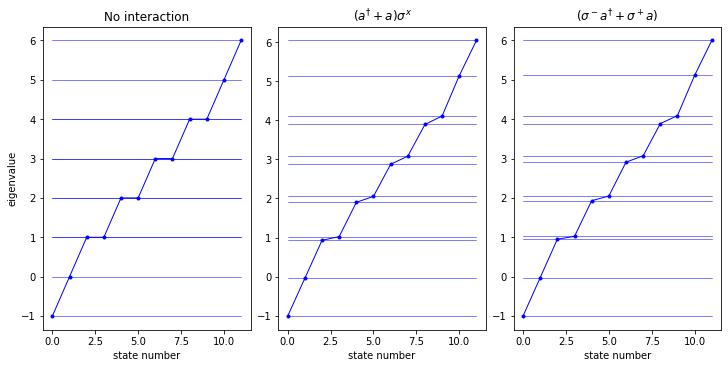

In [337]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
x = np.arange(H_full.Ns)
ax[0].plot(x,eigenvalues_H_no_interaction, '.-', color='b', lw=1.)
ax[1].plot(x,eigenvalues_H_full, '.-', color='b', lw=1.)
ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
for level in x :
    ax[0].plot(x,np.full(H_no_interaction.Ns,eigenvalues_H_no_interaction[level]), '-', color='b', lw=0.5)
    ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
    ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='$(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()

# Initial state

We prepare the system such that the atom is in its groundstate, while we put the photon mode in a coherent state with mean number of photonsNph,as required to by the semi-classical regime:
$$ \left|\psi_i\right> =  \left|\rm{coh}(N_{ph})\right>  \left|\downarrow\right> $$
We define the initial state as a product state.  Notice that in the QuSpinspin_basis_1d basis convention the state $\left|\downarrow\right>  = (1,0)^t$. This is because the spin basis statesare coded using their bit representations and the state of all spins pointing down is assignedthe integer 0.  To define the oscillator (a.k.a. photon) coherent state with mean photon number $N_{ph}$,  we use the function coherent_state: its first argument is the eigenvalue of the annihilation operator $a$, while the second argument is the total number of oscillator states

In [272]:
# define atom ground state
#psi_at_i=np.array([1.0,0.0]) # spin-down eigenstate of \sigma^z in QuSpin 0.2.3 or older
psi_atom_0=np.array([0.0,1.0])  # spin-down eigenstate of \sigma^z in QuSpin 0.2.6 or newer

In [273]:
# define photon coherent state with mean photon number Nph
psi_ph_0=coherent_state(np.sqrt(Nph),N_lev+1)

In [190]:
# compute atom-photon initial state as a tensor product
psi_0=np.kron(psi_atom_0,psi_ph_0)

# Calculate time evolution

The next step is to define a vector of stroboscopic times, using the class Floquet_t_vec.

In [191]:
# define time vector over 30 driving cycles with 100 points per period
t=Floquet_t_vec(Omega,30) # t.i = initial time, t.T = driving period

In [192]:
t.vals

array([0.00000000e+00, 6.28318531e-02, 1.25663706e-01, ...,
       1.88369896e+02, 1.88432727e+02, 1.88495559e+02])

We now time evolve the initial state susing the hamiltonian class method evolve. We define the solution psi_t as a generator expression using the optional argument iterate=True.

In [193]:
# evolve atom-photon state with Hamiltonian H (solves the Schrödingre equation using ODE integration routines)
#psi_t=H.evolve(psi_0,t.i,t.vals,iterate=True,rtol=1E-9,atol=1E-9) 

Another way: to construct time-evolution operator: $\hat{U} = \exp\{-i \hat{H} t\}$

In [194]:
U = exp_op(H, a=-1j, start=t.i, stop=t.vals[-1], num=len(t), iterate=True)
psi_t=U.dot(psi_0)

# Observables

Last, we define the observables of interest, using the hamiltonian class with unit coupling constants. 
Since each observable represents a single operator, we refrain from defining operator lists and set up the observables inline.  
The Python dictionaries obs_args and obs_args_sc represent another way of passing optional keyword arguments to the hamiltonian function. Here we also disable the automatic symmetry and hermiticity checks.

In [195]:
# define observables parameters
obs_args={"basis":basis,"check_herm":False,"check_symm":False, "check_pcon" : False}

In [196]:
# in atom-photon Hilbert space
n=hamiltonian([["|n", [[1.0  ]] ]],[],dtype=np.float64,**obs_args)
sz=hamiltonian([["z|",[[1.0,0]] ]],[],dtype=np.float64,**obs_args)
sy=hamiltonian([["y|",[[1.0,0]] ]],[],dtype=np.complex128,**obs_args)

We  calculate  the  time-dependent  expectation  values  using  the measurements tool function obs_vs_time. Its  arguments  are  the  time-dependent  state psi_t,  the  vector  of times t.vals, and a dictionary of all observables of interest. obs_vs_time returns a dictionary with all time-dependent expectations stored under the same keys they were passed. 

In [197]:
# in atom-photon Hilbert space
Obs_t = obs_vs_time(psi_t,t.vals,{"n":n,"sz":sz,"sy":sy})
O_n, O_sz, O_sy = Obs_t["n"], Obs_t["sz"], Obs_t["sy"]

From the eigenvalues: $\langle \psi | \sigma^z | \psi \rangle = \sum_n (|C_{n\uparrow}|^2 - |C_{n\downarrow}|^2) $ 

In [198]:
avg_sigmaz = (np.sum(eigenvalues[0:H.Ns//2]**2) - np.sum(eigenvalues[H.Ns//2::]**2))/(2*N_lev)**2
print(avg_sigmaz)

-1.3299592142375949


# Plot time evolution

/home/gorbunov8a/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gorbunov8a/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gorbunov8a/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


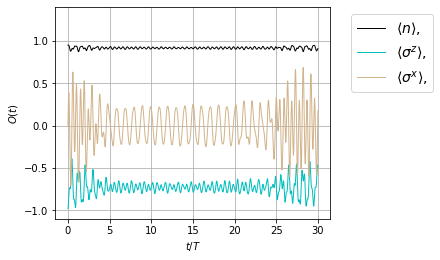

In [199]:
# plot spin-photon data
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))
ax.plot(t.vals/t.T,O_n/Nph,"k",linewidth=1,label="$\\langle n\\rangle,$")
ax.plot(t.vals/t.T,O_sz,"c",linewidth=1,label="$\\langle\\sigma^z\\rangle,$")
ax.plot(t.vals/t.T,O_sy,"tan",linewidth=1,label="$\\langle\\sigma^x\\rangle,$")
ax.plot(t.vals/t.T, np.full_like(t.vals, avg_sigmaz), 'k-')
ax.set(xlabel="$t/T$", ylabel=r'$O(t)$', ylim=[-1.1,1.4]); ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.show()